In [1]:
%matplotlib inline

In [2]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
from skimage.io import imread
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from google.colab import drive

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Multi class image Classification
## Image Recognition with Transfer Learning
#### Author: Daniela Yordanova

### Abstract
This project shows transfer learning technique for powerful image recognition, with keras, TensorFlow, and state-of-the-art pre-trained neural networks like VGG16, VGG19, and ResNet50.

The basic process steps include:

*  adding layers to an existing pre-trained neural network to adapt it to our needs
*  saving a keras model so that it can be re-used later on, without having to be retrained. 
*   evaluating the model performance

## Introduction
Modern convolutional neural networks such as VGG, ResNet, or Inception, would be able to perform image recognition with an accuracy over 99%. But these models are deep and complex. So they are hard to train, and a very large number of images are necessary to train these networks without overfitting .

In fact, these models are now trained on the [ImageNet](http://www.image-net.org/) dataset, which features over 14 million images sorted in 1000 categories. Compared to that, our Intel dataset, with its approx. 14 000 images, is ridiculously small. To cope with the reallity we are forced to use strong data augmentation to limit overfitting. So training a complex model on this dataset is out of question.

Within this project we are showing how we improve the classification performance on our small dataset if there is no way to train a complex model on this dataset. This is achieved via using transfer learning.

## Data loading and preprocessing

The data has been shared with Yordan Darakchiev under the following link: https://drive.google.com/drive/folders/1GwDmZ51G2-nvgBcfwZpGs2w9auBomtFL?usp=sharing_eil&invite=CJGD96cI&ts=602ec559

The data is orignally taken from Kaggle and can be found on the following link.

In [3]:
!wget https://www.kaggle.com/puneet6060/intel-image-classification

--2021-02-19 08:01:09--  https://www.kaggle.com/puneet6060/intel-image-classification
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘intel-image-classification’

intel-image-classif     [ <=>                ]  56.83K  --.-KB/s    in 0.003s  

2021-02-19 08:01:09 (19.6 MB/s) - ‘intel-image-classification’ saved [58194]



We will use our Google Drive to transfer and load the data following the next steps.

In [4]:
!unzip -q '/content/drive/My Drive/Intel_dataset.zip'

In [5]:
!unzip -u '/content/drive/My Drive/Intel_dataset.zip' -d '/content/drive/My Drive/Intel_dataset'

Archive:  /content/drive/My Drive/Intel_dataset.zip


In [6]:
# Accessing My Google Drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Intel_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
seg_pred  seg_test  seg_train


In [7]:
# Accessing My Google Drive
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/My Drive/Intel_dataset/seg_train/seg_train'

Mounted at /content/drive
buildings  forest  glacier  mountain  sea  street


We can re-use the following code originally taken from [Softuni, DEEP LEARNING - December 2020, Exam Preparation: End-to-end Project, live demo by Yordan Darakchiev](https://softuni.bg/trainings/resources/video/57530/video-03-february-2021-yordan-darakchiev-deep-learning-december-2020/2781).

In [8]:
data_path = '/content/drive/My Drive/Intel_dataset/seg_train/seg_train'
image_filenames = {}
for image_dir in os.listdir(data_path):
    image_dir_parts = image_dir.split(' ', maxsplit = 2)
    image_name = f'{image_dir_parts[0]}'
    print(image_dir)
    
    full_image_dir = os.path.join(data_path, image_dir)
    files_in_image_dir = os.listdir(full_image_dir)
    files_in_image_dir = [os.path.join(full_image_dir, file) for file in files_in_image_dir]
    files_in_image_dir = [os.path.abspath(file) for file in files_in_image_dir]
    
    if image_name not in image_filenames:
        image_filenames[image_name] = []
    
    image_filenames[image_name].extend(files_in_image_dir)

buildings
forest
glacier
mountain
sea
street


In [9]:
# Prepare the images into dataframe with corresponding label (class)
image_filenames_df = pd.DataFrame({'filename': [], 'class': []})

for (image_name, filenames) in image_filenames.items():
    records = [{'filename': filename, 'class': image_name} for filename in filenames]
    image_filenames_df = image_filenames_df.append(records)

In [10]:
# Let's have a look at the dataframe
image_filenames_df

filename      class
0     /content/drive/My Drive/Intel_dataset/seg_trai...  buildings
1     /content/drive/My Drive/Intel_dataset/seg_trai...  buildings
2     /content/drive/My Drive/Intel_dataset/seg_trai...  buildings
3     /content/drive/My Drive/Intel_dataset/seg_trai...  buildings
4     /content/drive/My Drive/Intel_dataset/seg_trai...  buildings
...                                                 ...        ...
2377  /content/drive/My Drive/Intel_dataset/seg_trai...     street
2378  /content/drive/My Drive/Intel_dataset/seg_trai...     street
2379  /content/drive/My Drive/Intel_dataset/seg_trai...     street
2380  /content/drive/My Drive/Intel_dataset/seg_trai...     street
2381  /content/drive/My Drive/Intel_dataset/seg_trai...     street

[14034 rows x 2 columns]

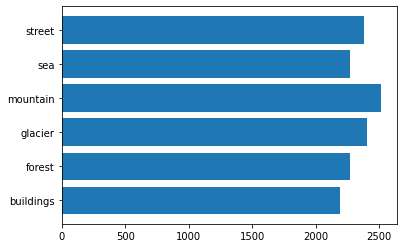

In [11]:
# Now we can group the images by corresponding class they belong to
groups_by_num_images = image_filenames_df.groupby('class').size()
plt.barh(groups_by_num_images.index, groups_by_num_images)
plt.show()

In [12]:
groups_by_num_images

class
buildings    2191
forest       2271
glacier      2404
mountain     2512
sea          2274
street       2382
dtype: int64

In [13]:
image_filenames_df.groupby('class').count()

filename
class              
buildings      2191
forest         2271
glacier        2404
mountain       2512
sea            2274
street         2382

In [14]:
image_filenames_df['class'].describe()

count        14034
unique           6
top       mountain
freq          2512
Name: class, dtype: object

In [15]:
# list of classes (labels, categories) used for the classification
classes_list = np.array(list(os.listdir(data_path)))
list(classes_list)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [16]:
# number of classes to train on
num_classes = len(classes_list)
num_classes

6

We have 6 unique classes. The number of images is almost equally splited among the classes so we can accept the adtaset is almost balanced. If it was not the case the oversampling might apply. 

Now we can check if some of the images are properly loaded and explore some of the images features like shape (height and width of the image in pixels) and color channels (RGB).

In [17]:
# Let's take a sample of ten images
sampled_images = image_filenames_df.sample(10)

In [18]:
# define a function to display the images
def display_images(image_descriptors):
    for filename, model_class in image_descriptors.values:
        try:
            image = imread(filename)
            plt.imshow(image)
            plt.title(model_class)
            print('image shape', image.shape, 'maximum color level', image.max())
            plt.show()
        except:
            print(f'Could not read {filename}')
            continue

image shape (150, 150, 3) maximum color level 255


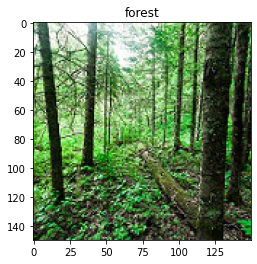

image shape (150, 150, 3) maximum color level 255


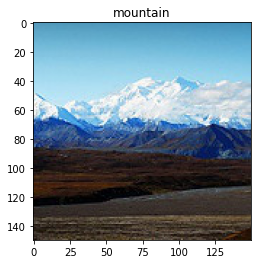

image shape (150, 150, 3) maximum color level 255


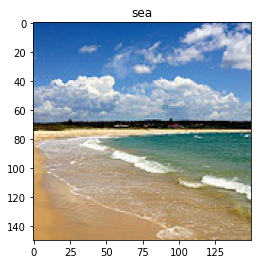

image shape (150, 150, 3) maximum color level 255


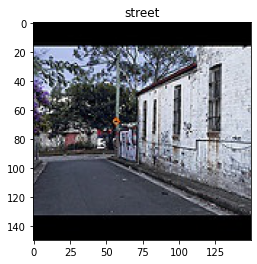

image shape (150, 150, 3) maximum color level 255


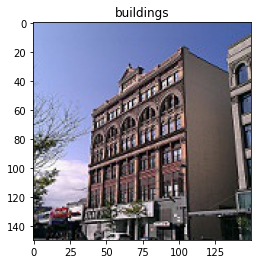

image shape (150, 150, 3) maximum color level 255


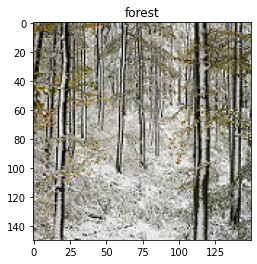

image shape (150, 150, 3) maximum color level 255


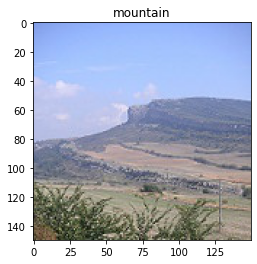

image shape (150, 150, 3) maximum color level 255


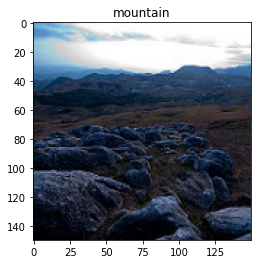

image shape (150, 150, 3) maximum color level 255


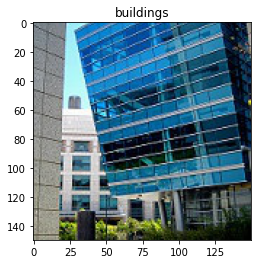

image shape (150, 150, 3) maximum color level 247


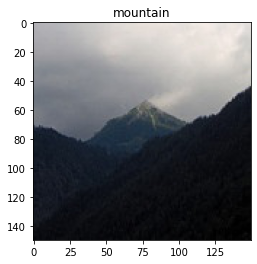

In [19]:
display_images(sampled_images)

In the image shape, the first two columns correspond to the height and width of the image in pixels, respectively, and the third one to the three color channels. So each pixel contains three values (for red, green, and blue, respectively). We also printed the maximum color level in each channel, and we can conclude that the RGB levels are in the range 0-255.

In the next section, we will use Keras to retrieve images from disk with the [flow_from_directory](https://keras.io/api/preprocessing/image/#flow_from_directory) method of the [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class. 
By ImageDataGenerator we will turn our images, now files on disk, into batches of data arrays that can be fed to the network during training. The method flow_from_directory method of the ImageDataGenerator object will start generating and returning batches everytime it's iterated on. 

Let's define two functions that will be used later on.

In [20]:
# Define function that returns image iterators that will be used to produce batches of images
# for the training and the validation of our neural network

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        directory = data_path,
        target_size = (height, width), 
        classes = list(classes_list),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        directory = data_path,
        target_size = (height, width), 
        classes = list(classes_list),
        batch_size = batch_size,
        shuffle = False,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [21]:
  # Define function that will be used to plot the accuracy and loss as a function of the epoch, so that we can see how the training worked. 
  # To get a feeling for overfitting, these quantities will be plotted for both the training and validation datasets
  
  def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch, for the training and validation datasets.
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train_dataset', 'val_dataset'], loc='upper right')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train_dataset', 'val_dataset'], loc='upper right')
    plt.ylim(yrange)
    
    plt.show()

We're now ready to get started with our first pre-trained model.

## Pre-trained model

In [22]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

The classifier is adapted to the 1000 categories of ImageNet. However our task is to classify only 6 categories.
And with Keras, we can import only the convolutional part of VGG16, by setting the include_top parameter to False:

In [23]:
vgg16 = keras.applications.vgg16
vgg16_conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg16_conv_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

The convolutional model can already be used to extract the features for a given image. Let's check it:

0.0 255.0
(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 512)


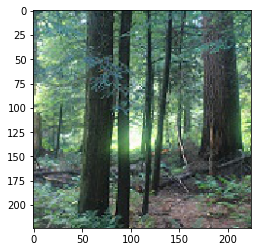

In [24]:
img_path = '/content/drive/My Drive/Intel_dataset/seg_train/seg_train/forest/98.jpg'

# loading the image: 
img = image.load_img(img_path, target_size=(224, 224))
# converts the image to a numpy array
x = image.img_to_array(img)
print(np.min(x), np.max(x))
print(x.shape)
# expand the shape of the array. Insert a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)
print(xs.shape)
# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)
# evaluate the model to extract the features
features = vgg16_conv_model.predict(xs)
plt.imshow(img)
print(features.shape)

VGG16 takes images of shape (224,224,3)- three color channels in 224x224 pixels. So first, we have loaded an image and then converted it to a numpy array of shape (224,224,3). Then the image is stored in a numpy array with shape (n,224,224,3), where n is the number of images to be processed. In our case this is an array of shape (1,224,224,3) with np.expand_dims.

Since our project relies on transfer learning technique, now by adopting the feature extraction provided by the convolutional part of the pre-trained VGG16 neural network we can re-use it by extending it with our own classifier. 

## Custom classification with VGG16, VGG19, ResNet50 Transfer Learning

### Transfer Learning with VGG16

In [the Keras documentation for VGG16](https://keras.io/api/applications/#vgg16) we see that the input of VGG16 should be images with 224x224 pixels. So we create training and validation iterators to produce such images, with the function we have defined at the beginning of the project.

In [25]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


And this is exactly the split between train and validation images used to clasiffy based on the number of classes we have defined above.

Let's create the convolutional part again, as we need to specify the input_shape this time to be able to create the full model:

In [26]:
vgg16_conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

Finally, we insert the output of the convolutional part into a classifier.

In [27]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(vgg16_conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories
predictions = keras.layers.Dense(len(set(classes_list)), activation='softmax')(x)

# creating the full model:
vgg16_full_model = keras.models.Model(inputs=vgg16_conv_model.input, outputs=predictions)
vgg16_full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Next, we will freeze all the layers of the convolutional part.

In [28]:
for layer in vgg16_conv_model.layers:
    layer.trainable = False

The only layers that will be trained are the ones of the dense classifier.

In [29]:
vgg16_full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Indeed, we see that the number of trainable parameters is the total number of parameters in the last 4 dense layers.

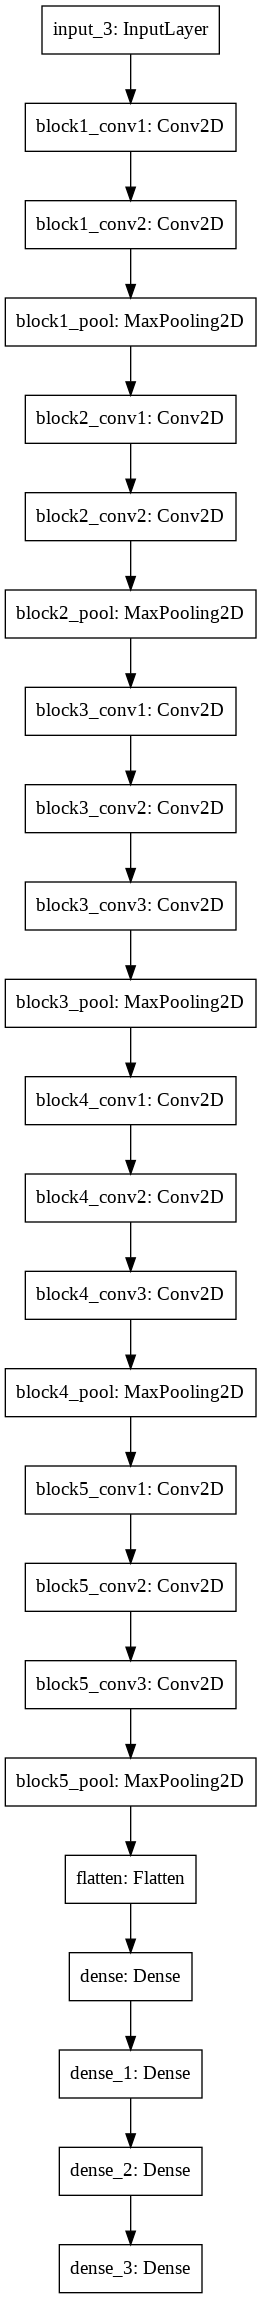

In [30]:
# Model plotting
tf.keras.utils.plot_model(model = vgg16_full_model)

We can now compile and train the model.

In [31]:
vgg16_full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['acc'])
history = vgg16_full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
375/375 [==============================] - 375s 975ms/step - loss: 0.9446 - acc: 0.8292 - val_loss: 0.5602 - val_acc: 0.8645
Epoch 2/10
375/375 [==============================] - 57s 151ms/step - loss: 0.3318 - acc: 0.9117 - val_loss: 0.3880 - val_acc: 0.9112
Epoch 3/10
375/375 [==============================] - 59s 156ms/step - loss: 0.2104 - acc: 0.9411 - val_loss: 0.5599 - val_acc: 0.8809
Epoch 4/10
375/375 [==============================] - 59s 158ms/step - loss: 0.2011 - acc: 0.9438 - val_loss: 0.4318 - val_acc: 0.9066
Epoch 5/10
375/375 [==============================] - 60s 160ms/step - loss: 0.1515 - acc: 0.9596 - val_loss: 0.3772 - val_acc: 0.9101
Epoch 6/10
375/375 [==============================] - 62s 163ms/step - loss: 0.1047 - acc: 0.9698 - val_loss: 0.3923 - val_acc: 0.9133
Epoch 7/10
375/375 [==============================] - 62s 164ms/step - loss: 0.1107 - acc: 0.9676 - val_loss: 0.4926 - val_acc: 0.9123
Epoch 8/10
375/375 [==============================] - 

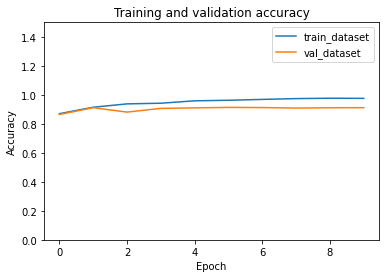

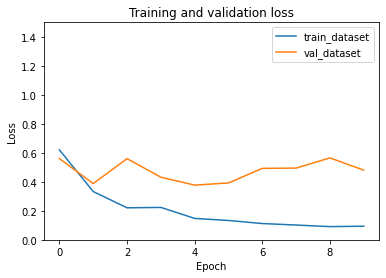

In [32]:
plot_history(history, yrange=(0, 1.5))

We see that the model is very fast to train, as we just need to train the classifier part. One epoch is actually enough to reach a validation accuracy of 92%. After that, the accuracy plateaus. Overfitting is moderate and is limiting performance. We could work on overfitting by simplifying the classifier, or by adding a dropout layer just before the classifier.

### Transfer Learning with VGG19

VGG19 is the most recent version of the VGG models and is very similar to VGG16. If you compare the model summary below to the one of VGG16, you will see that the architecture is the same, and is still based on five convolutional blocks. However, the depth of the network has been further increased by adding a convolutional layer in the last three blocks. The input is still an RGB image of shape (224,224,3), and the output a feature tensor of shape (7,7,512). For VGG19 we can use the same functions as VGG16.

Now let's build and check the full model:

In [33]:
vgg19 = keras.applications.vgg19
vgg19_conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg19_conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(vgg19_conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(len(set(classes_list)), activation='softmax')(x)
vgg19_full_model = keras.models.Model(inputs=vgg19_conv_model.input, outputs=predictions)
vgg19_full_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

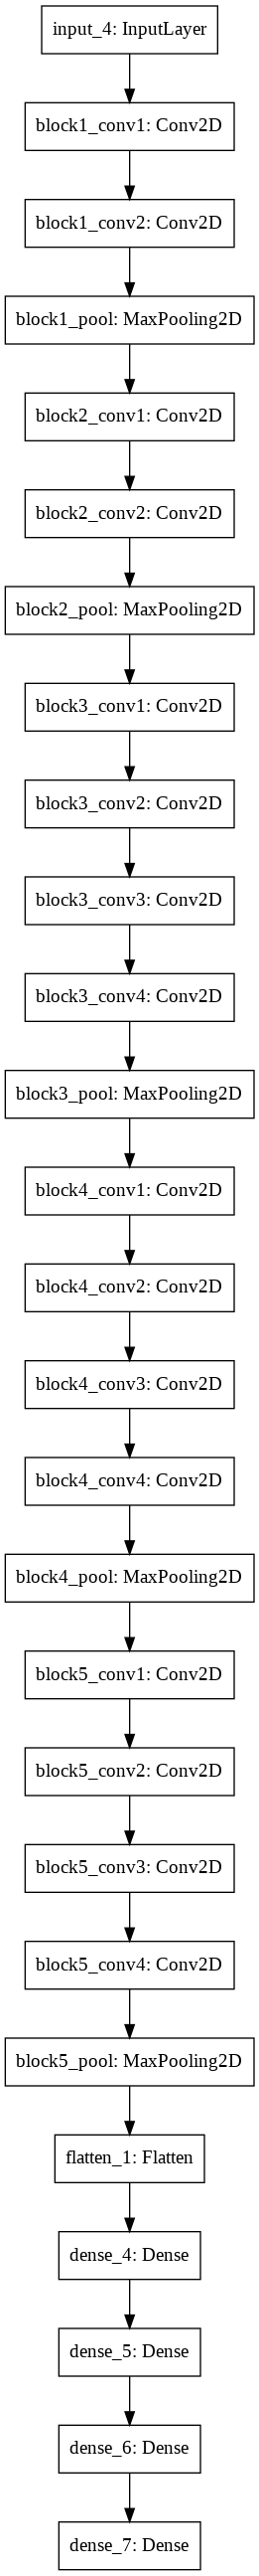

In [34]:
# Model plotting
tf.keras.utils.plot_model(model = vgg19_full_model)

In [35]:
vgg19_full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['acc'])
history = vgg19_full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
375/375 [==============================] - 77s 203ms/step - loss: 1.1453 - acc: 0.8093 - val_loss: 0.3829 - val_acc: 0.8902
Epoch 2/10
375/375 [==============================] - 76s 201ms/step - loss: 0.2897 - acc: 0.9146 - val_loss: 0.3546 - val_acc: 0.9083
Epoch 3/10
375/375 [==============================] - 77s 202ms/step - loss: 0.2646 - acc: 0.9350 - val_loss: 0.3600 - val_acc: 0.9155
Epoch 4/10
375/375 [==============================] - 76s 202ms/step - loss: 0.1717 - acc: 0.9485 - val_loss: 0.3820 - val_acc: 0.9076
Epoch 5/10
375/375 [==============================] - 76s 201ms/step - loss: 0.1374 - acc: 0.9615 - val_loss: 0.3368 - val_acc: 0.9112
Epoch 6/10
375/375 [==============================] - 77s 202ms/step - loss: 0.1095 - acc: 0.9681 - val_loss: 0.3936 - val_acc: 0.9098
Epoch 7/10
375/375 [==============================] - 77s 202ms/step - loss: 0.1170 - acc: 0.9688 - val_loss: 0.3781 - val_acc: 0.9108
Epoch 8/10
375/375 [==============================] - 7

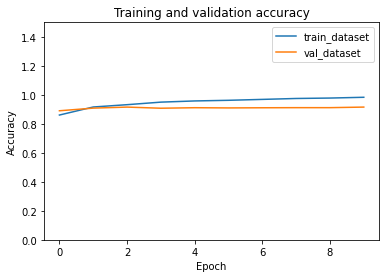

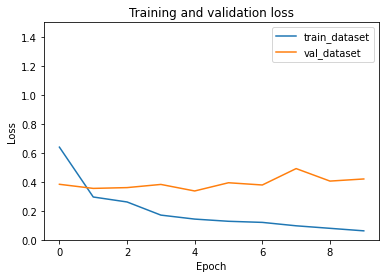

In [36]:
plot_history(history, yrange=(0.0, 1.5))

### Transfer Learning with ResNet-50

In [the Keras documentation for ResNet50](https://keras.io/api/applications/#vgg16) we see that the input data should be images with 224x224 pixels. So, we create training and validation iterators to produce such images, with the function we have defined at the beginning of the project.

First, we create our dataset iterators, with the right input shape and preprocessing functions.

In [37]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


Then, we create our full model, that is the convolutional part of ResNet50 followed by our simple classifier and we train it.

In [38]:
restnet50_conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in restnet50_conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(restnet50_conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(len(set(classes_list)), activation='softmax')(x)
restnet50_full_model = keras.models.Model(inputs=restnet50_conv_model.input, outputs=predictions)
restnet50_full_model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [39]:
restnet50_full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['acc'])
history = restnet50_full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
    callbacks = [TensorBoard(log_dir = 'logs_transfer_original')]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
375/375 [==============================] - 60s 152ms/step - loss: 0.7278 - acc: 0.8349 - val_loss: 0.2848 - val_acc: 0.9058
Epoch 2/10
375/375 [==============================] - 56s 147ms/step - loss: 0.2361 - acc: 0.9309 - val_loss: 0.3194 - val_acc: 0.9083
Epoch 3/10
375/375 [==============================] - 56s 148ms/step - loss: 0.1751 - acc: 0.9493 - val_loss: 0.3374 - val_acc: 0.9130
Epoch 4/10
375/375 [==============================] - 55s 146ms/step - loss: 0.1357 - acc: 0.9568 - val_loss: 0.3490 - val_acc: 0.9173
Epoch 5/10
375/375 [==============================] - 56s 147ms/step - loss: 0.1052 - acc: 0.9679 - val_loss: 0.3162 - val_acc: 0.9208
Epoch 6/10
375/375 [==============================] - 56s 147ms/step - loss: 0.0862 - acc: 0.9740 - val_loss: 0.3660 - val_acc: 0.9123
Epoch 7/10
375/375 [==============================] - 56s 147ms/step - loss: 0.0675 - acc: 0.9814 - val_loss: 0.4047 - val_acc: 0.9251
Epoch 8/10
375/375 [==============================] - 5

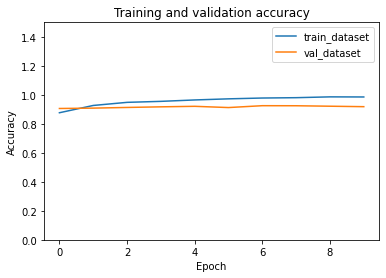

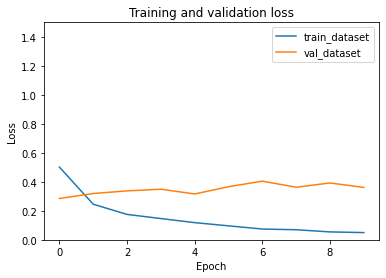

In [40]:
plot_history(history, yrange=(0.0, 1.5))

[[8.7374229e-20 1.0000000e+00 6.5108405e-11 7.6912069e-14 1.1398075e-15
  2.1422280e-19]]


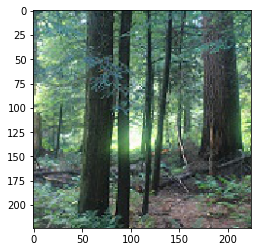

In [41]:
from keras.applications.resnet50 import preprocess_input

img_path = '/content/drive/My Drive/Intel_dataset/seg_train/seg_train/forest/98.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(restnet50_full_model.predict(x))
plt.imshow(img)

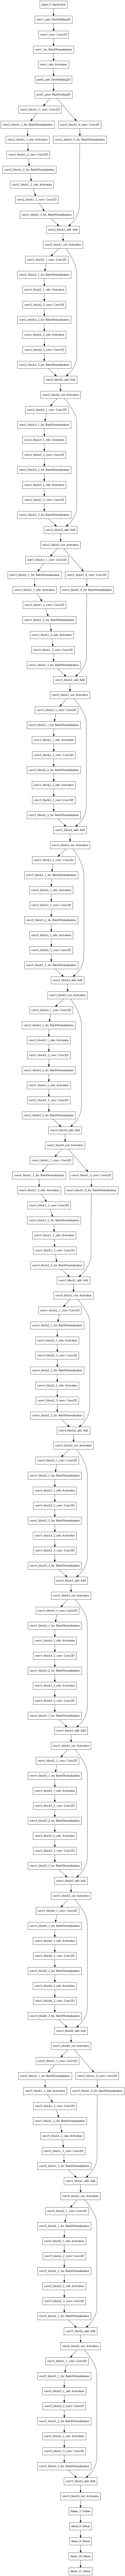

In [42]:
# Model plotting
tf.keras.utils.plot_model(model = restnet50_full_model)

In [43]:
batch = train_dataset.next()
len(batch)

2

In [44]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [45]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)

(30, 224, 224, 3)
float32
151.061
(30, 6)
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


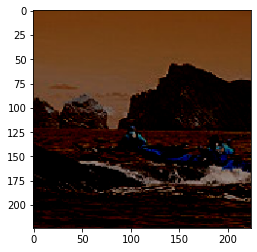

In [46]:
import numpy as np
# we need to cast the image array to integers 
# before plotting as imshow either takes arrays of integers, 
# or arrays of floats normalized to 1. 
plt.imshow(batch[0][0].astype(np.int))

In [47]:
batch[1][0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [48]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 5,6
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(np.int))
      plt.title( '{}'.format(str(label)))
      plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

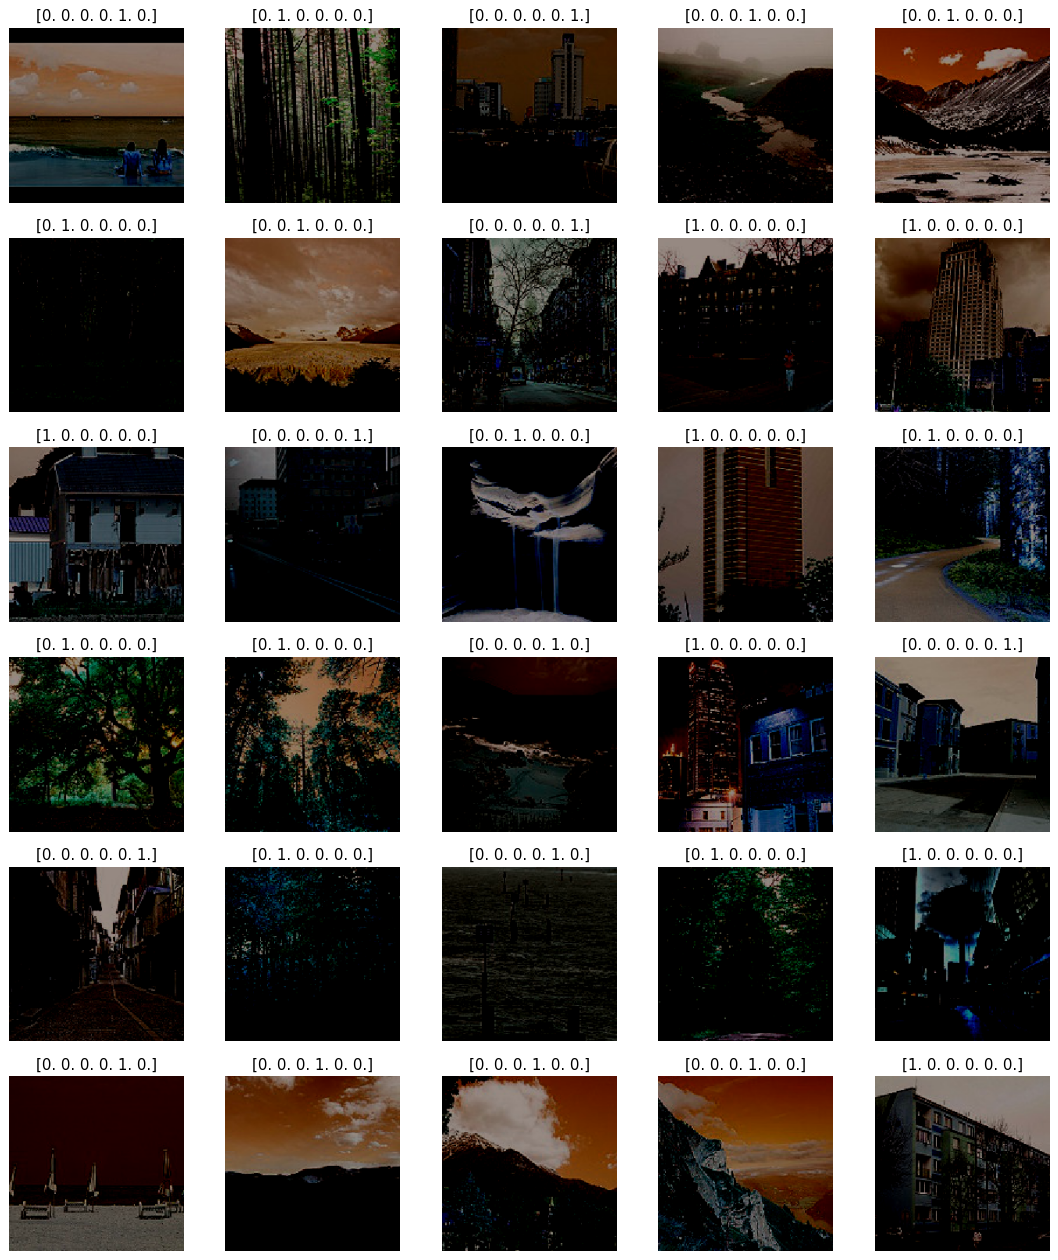

In [49]:
plot_images(train_dataset.next())

#### Model saving

If we want to save the model for future use we can follow the next steps:

In [50]:
# Save the model weights (parameters)
restnet50_full_model.save_weights('resnet50.h5')

In [51]:
# Create a new model, identical to the one we have trained
restnet50_conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in restnet50_conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(restnet50_conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(len(set(classes_list)), activation='softmax')(x)
restnet50_full_model = keras.models.Model(inputs=restnet50_conv_model.input, outputs=predictions)

In [52]:
# Load the weights
restnet50_full_model.load_weights('resnet50.h5')

#### Model evaluation

In [53]:
#Create Classification Report
Y_pred = restnet50_full_model.predict_generator(val_dataset)
y_pred = np.argmax(Y_pred, axis=1)
#print('\n---Confusion Matrix---')
#print(confusion_matrix(val_dataset.classes, y_pred))
print('\n---Classification Report---')
target_names = list(classes_list)
print(classification_report(val_dataset.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



---Classification Report---
              precision    recall  f1-score   support

   buildings       0.90      0.95      0.92       438
      forest       0.99      0.98      0.99       454
     glacier       0.93      0.80      0.86       480
    mountain       0.83      0.93      0.87       502
         sea       0.95      0.94      0.94       454
      street       0.94      0.93      0.93       476

    accuracy                           0.92      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.92      0.92      0.92      2804



In [54]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [55]:
Y_pred = restnet50_full_model.predict_generator(val_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_dataset.classes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion matrix, without normalization


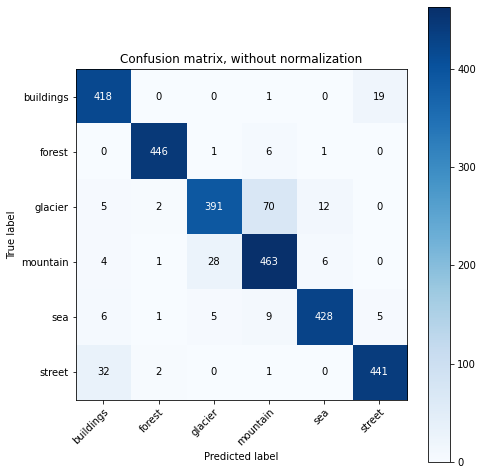

In [56]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=list(classes_list)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


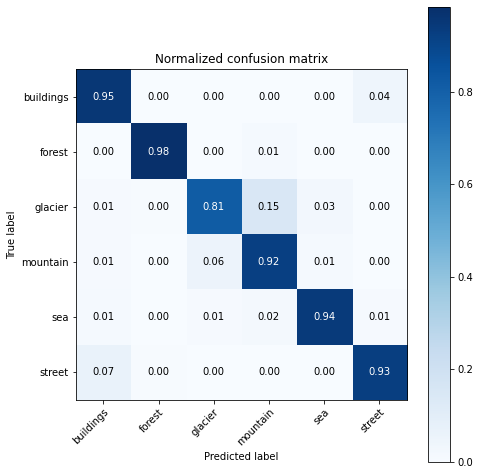

In [57]:
#Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize = True, title = 'Normalized confusion matrix')

Based on above confusion matrix and classification report figures we can conclude that our model generalize on the validation dataset pretty well with above than 90% accuracy/ f1 score in terms of all the calsses except two of them- mountain and glacier. This might be because of the shape of the objects both classes represent. Slight classification error (predicted vs. true classes) dependancy might be registered about classification of glacier vs. sea from  and buldings vs. street.

### Discussion and Future Work

In this project, we've shown what is transfer learning and how to:
*  use the VGG16, VGG19, and ResNet50 pre-trained models in keras
*  add layers to an existing model to adapt it to our needs 
*  save a keras model so that you can re-use it later on, without having to retrain.
*  create own tools to evaluate the model performance

We have proved that Deep neural networks trained on the large ImageNet dataset can be used to classify images in different categories, and with smaller dataset.

Moreover, we can re-use it to classify our own set of images. Why not? Transfer learning is the way to go.

Next, we'll build a dataset from scratch by collecting images on the internet. With this dataset, we will be able to test our transfer learning skills on different, yet unknown categories. 

## Conclusion

In this project, we've shown what is transfer learning and how to:

use the VGG16, VGG19, and ResNet50 pre-trained models in keras
add layers to an existing model to adapt it to our needs
save a keras model so that you can re-use it later on, without having to retrain.
create own tools to evaluate the model performance
We have proved that Deep neural networks trained on the large ImageNet dataset can be used to classify images in different categories, and with smaller dataset.

Moreover, we can re-use it to classify our own set of images. Why not? Transfer learning is the way to go.

Next, we'll build a dataset from scratch by collecting images on the internet. With this dataset, we will be able to test our transfer learning skills on different, yet unknown categories.

## References

[1] Deep Learning course, SoftUni, trainer Yordan Darakchiev: https://softuni.bg

[2] Deep Learning course, SoftUni, trainer Yordan Darakchiev: https://softuni.bg/trainings/resources/video/57530/video-03-february-2021-yordan-darakchiev-deep-learning-december-2020/2781

[3] ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION: https://arxiv.org/pdf/1412.6980.pdf

[4] FlowersClassiﬁcationviaDeepLearning: http://noiselab.ucsd.edu/ECE228_2019/Reports/Report40.pdf

[5] https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function

[6] https://keras.io/api/preprocessing/image/

[7] https://keras.io/api/applications/#vgg16

[8] https://www.xspdf.com/resolution/59824816.html

[9] https://stackoverflow.com/questions/49351071/load-image-dataset-folder-or-zip-located-in-google-drive-to-google-colab

[10] https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92

[11] https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/

[12] https://thedatafrog.com/en/articles/image-recognition-transfer-learning/